In [1]:
import os # Avoids the OpenMP error when used in conjunction with the below command 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

import requests
import pandas as pd
from sklearn.model_selection import train_test_split

import arviz as az

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device = ",device)

if device.type == "cpu":
    cuda = False
else:
    cuda = True

Device =  cpu


In [1]:
import os  # Avoids the OpenMP error in conjunction with the below
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from livelossplot import PlotLosses
import pandas as pd
import requests 
import time
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device = ",device)
if device.type == "cpu":
    cuda = False
else:
    cuda = True
    

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)   # Suppress the future warning in sns distplot
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) # Suppress the numpy warnings about indexing arrays

# Adds the above directory to system path 
import sys
sys.path.append('../')
  
# Importing the Bayesian LR module
from multi_dim_regression_stats import *
from multi_dim_regression_import_data import *

# Specific to this method
from torchvision import datasets, transforms
from torchvision.utils import make_grid

Device =  cpu


In [3]:
def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma)
    
    return - (log_coeff + exponent).sum()


#def get_kl_divergence(weights, prior, varpost):
#    prior_loglik = prior.loglik(weights)
#    
#    varpost_loglik = varpost.loglik(weights)
#    varpost_lik = varpost_loglik.exp()
#    
#    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [4]:
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        scale = (2/self.input_dim)**0.5
        rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.05, 0.05))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-2, -1))
        
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.05, 0.05))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-2, -1))
        
    def forward(self, x, sample = True):
        
        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the KL loss term
            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
            KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
            KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            return output, KL_loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss
        
    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
        return all_samples

In [5]:
class BBP_Homoscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, no_units, init_log_noise):
        super(BBP_Homoscedastic_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, no_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(no_units, output_dim, gaussian(0,1))
        #self.layer2 = BayesLinear_Normalq(no_units, no_units, gaussian(0, 1))
        #self.layer3 = BayesLinear_Normalq(no_units, output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        #self.activation = torch.sin
        self.log_noise = nn.Parameter(torch.FloatTensor([init_log_noise]))

    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        # First hidden layer
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        # Second hidden layer
        # This *really* messes up the model
        #x, KL_loss = self.layer2(x)
        #KL_loss_total = KL_loss_total + KL_loss
        #x = self.activation(x)
        
        # Output layer
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total

In [6]:
class BBP_Homoscedastic_Model_Wrapper:
    def __init__(self, input_dim, output_dim, no_units, learn_rate, batch_size, no_batches, init_log_noise):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = BBP_Homoscedastic_Model(input_dim = input_dim, output_dim = output_dim,
                                               no_units = no_units, init_log_noise = init_log_noise)
        #self.network.cuda()
        
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr = self.learn_rate) 
        # self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=False)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss_total = fit_loss_total + self.loss_func(output, y, self.network.log_noise.exp(), self.network.output_dim)
        
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total

# Define true function and training/test data 

In [7]:
def normalise(x, mean, std):
    return (x - mean)/std 

def unnormalise(x, mean, std):
    return (x * std) + mean

In [8]:
# Import data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
s = requests.get(url).content
xl = pd.ExcelFile(s)  
df = pd.read_excel(s, header = 0)
df_len = len(df)

In [9]:
from scipy.spatial.distance import cdist, euclidean

def geometric_median(X, eps=1e-5):
    # From: https://stackoverflow.com/questions/30299267/geometric-median-of-multidimensional-points
    # Implements the L1-median median as described in "The multivatiate L1-median and associated data depth" (Y. Vardi et al, 1999)
    # Available at: https://www.pnas.org/doi/pdf/10.1073/pnas.97.4.1423
    y = np.mean(X, 0)

    while True:
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1

In [10]:
def euclid_dist(df, origin):
    num_parameters = len(df.columns)-1
    num_datapoints = len(df)
    euclid_dist = np.zeros(num_datapoints)
    
    for datapoint in range(0, num_datapoints):
        for param in range(0, num_parameters):
            euclid_dist[datapoint] += (df[df.columns[param]][datapoint] - origin[param])**2
        euclid_dist[datapoint] = np.sqrt(euclid_dist[datapoint])
    
    return euclid_dist

 C:\Users\aolux\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


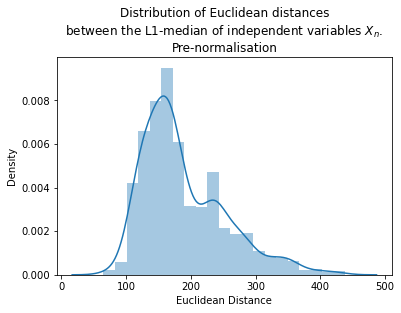

In [11]:
# Calculate the geometric median and the euclidean distances between every datapoint and the median
median = geometric_median(df.to_numpy()[:,:8])
euclid_dists = euclid_dist(df, median)

# Visualise the distribution of distances
import seaborn as sns

sns.distplot(euclid_dists);
plt.title("Distribution of Euclidean distances\nbetween the L1-median of independent variables $X_n$.\nPre-normalisation");
plt.xlabel("Euclidean Distance");

# Append the distances to the dataframe
df["L2 Dist from Geometric Median"] = euclid_dists.tolist()

# Normalise the dataframe
data_mean = df.mean()
data_std = df.std()
df=normalise(df, data_mean, data_std)  # Normalise data

In [12]:
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)",L2 Dist from Geometric Median
0,2.476715,-0.856470,-0.846721,-0.916218,-0.619924,0.862741,-1.217067,-0.279597,2.643908,1.805467
1,2.476715,-0.856470,-0.846721,-0.916218,-0.619924,1.055658,-1.217067,-0.279597,1.560519,1.858505
2,0.491204,0.795146,-0.846721,2.174311,-1.038440,-0.526258,-2.239824,3.551340,0.266478,2.093813
3,0.491204,0.795146,-0.846721,2.174311,-1.038440,-0.526258,-2.239824,5.055221,0.313363,3.227706
4,-0.790048,0.678084,-0.846721,0.488568,-1.038440,0.070497,0.647594,4.976069,0.507506,2.411481


In [13]:
## Split off the 'validation' data - i.e. OoD points
# Choose the component to oder by. Order of components:
# Cement, slag, fly ash, water, superplasticizer, coarse aggregate, fine aggregate, age, compressive strength, euclid dist
# [0]      [1]   [2]      [3]         [4]              [5]               [6]         [7]      [8]               [9]
component = 9   # Component to sort by 
y_index = 8     # Column number of the dependent variable. Make sure to change this IF ADDING ANY ROWS 
component_name = list(df.columns.values)[component]
print("Ordering by: ",component_name)
print("y variable: ",list(df.columns.values)[y_index])

# What percentage of samples to draw off from the top and bottom of distribution
cutoff_percentile = 0.05   

# Sort dataframe and then cut off the top and bottom values dependent on the percentile chosen
df = df.sort_values(df.columns[component])
df = df.reset_index(drop=True)
upper = df[df[df.columns[component]] < df[df.columns[component]].quantile(cutoff_percentile)]
lower = df[df[df.columns[component]] > df[df.columns[component]].quantile(1-cutoff_percentile)]

upper_indices = df[df.columns[component]] < df[df.columns[component]].quantile(cutoff_percentile)
upper_indices = upper_indices[upper_indices==True].index.values

lower_indices = df[df.columns[component]] > df[df.columns[component]].quantile(1-cutoff_percentile)
lower_indices = lower_indices[lower_indices==True].index.values

print("Cutting ",len(upper), " values off the top and ",len(lower), " off the bottom of the ordered dataset.")

# Combine upper and lower dfs to validation set
validation_data = pd.concat([upper, lower])

# Delete these rows from the main df 
df = df.drop(df[df[df.columns[component]] < df[df.columns[component]].quantile(cutoff_percentile)].index)
df = df.drop(df[df[df.columns[component]] > df[df.columns[component]].quantile(1-cutoff_percentile)].index)

# Split the remaining data to training and test 
train_data, test_data = train_test_split(df, test_size=0.2,random_state=1234) # Note: this preserves the indices

x_train = torch.tensor(train_data.iloc[:,:y_index].values).float()
y_train = torch.tensor(train_data.iloc[:,y_index].values).float().unsqueeze(1)
train_indices = train_data.index.values

x_test = torch.tensor(test_data.iloc[:,:y_index].values).float()
y_test = torch.tensor(test_data.iloc[:,y_index].values).float().unsqueeze(1)
test_indices = test_data.index.values

x_val = torch.tensor(validation_data.iloc[:,:y_index].values).float()
y_val = torch.tensor(validation_data.iloc[:,y_index].values).float().unsqueeze(1)
val_indices = np.concatenate((upper_indices,lower_indices))

print(f"Split data with {len(x_train)} ({100*len(x_train)/df_len:.2f}%) training points, "
      f"{len(x_test)} ({100*len(x_test)/df_len:.2f}%) testing points and "
      f"{len(x_val)} ({100*len(x_val)/df_len:.2f}%) validation points.")

Ordering by:  L2 Dist from Geometric Median
y variable:  Concrete compressive strength(MPa, megapascals) 
Cutting  52  values off the top and  52  off the bottom of the ordered dataset.
Split data with 743 (72.14%) training points, 186 (18.06%) testing points and 104 (10.10%) validation points.


In [14]:
num_epochs = 2000
batch_size = len(x_train)

net = BBP_Homoscedastic_Model_Wrapper(input_dim = 8,
                                      output_dim = 1,
                                      no_units = 100,
                                      learn_rate = 5e-1,
                                      batch_size = batch_size,
                                      no_batches = 1,
                                      init_log_noise = 0)

fit_loss_train = np.zeros(num_epochs)
KL_loss_train = np.zeros(num_epochs)
total_loss = np.zeros(num_epochs)

best_net = None
best_loss = float('inf')

for i in range(num_epochs):
    
    fit_loss, KL_loss = net.fit(x_train, y_train, no_samples = 10)   # Increasing the number of samples increases time taken dramatically
    fit_loss_train[i] += fit_loss.cpu().data.numpy()
    KL_loss_train[i] += KL_loss.cpu().data.numpy()
    
    total_loss[i] = fit_loss_train[i] + KL_loss_train[i]
    
    if fit_loss < best_loss:
        best_loss = fit_loss
        best_net = copy.deepcopy(net.network)
        
    if i % 100 == 0 or i == num_epochs - 1:
        
        print("Epoch: %5d/%5d, Fit loss = %8.3f, KL loss = %8.3f, noise = %6.3f" %
              (i + 1, num_epochs, fit_loss_train[i], KL_loss_train[i], net.network.log_noise.exp().cpu().data.numpy()))

Epoch:     1/ 2000, Fit loss =  746.909, KL loss = 1126.258, noise =  1.657
Epoch:   101/ 2000, Fit loss =  469.486, KL loss = 1170.396, noise =  1.141
Epoch:   201/ 2000, Fit loss =   88.513, KL loss = 1210.006, noise =  0.683
Epoch:   301/ 2000, Fit loss =  116.467, KL loss = 1241.275, noise =  0.709
Epoch:   401/ 2000, Fit loss =   29.394, KL loss = 1262.090, noise =  0.631
Epoch:   501/ 2000, Fit loss =   48.839, KL loss = 1278.068, noise =  0.648
Epoch:   601/ 2000, Fit loss =  258.856, KL loss = 1292.478, noise =  0.859
Epoch:   701/ 2000, Fit loss =  672.943, KL loss = 1305.788, noise =  1.500
Epoch:   801/ 2000, Fit loss =  -52.031, KL loss = 1317.166, noise =  0.566
Epoch:   901/ 2000, Fit loss =  -68.859, KL loss = 1326.340, noise =  0.553
Epoch:  1001/ 2000, Fit loss =  630.125, KL loss = 1334.152, noise =  1.416
Epoch:  1101/ 2000, Fit loss = -178.032, KL loss = 1341.061, noise =  0.477
Epoch:  1201/ 2000, Fit loss =  651.467, KL loss = 1346.645, noise =  1.458
Epoch:  1301

In [15]:
def generate_samples(net_, data, num_samples):
    samples = []
    for i in range(num_samples):
        preds = best_net.forward(data)[0]
        samples.append(preds.cpu().data.numpy()[:, 0])
        
    samples = np.array(samples)
    samples = unnormalise(samples, data_mean[y_index], data_std[y_index])
    means = (samples.mean(axis = 0)).reshape(-1)
    stds = (samples.std(axis = 0)).reshape(-1)
    return samples, means, stds

samples_test, means_test, stds_test = generate_samples(net, x_test, 1000)
samples_train, means_train, stds_train = generate_samples(net, x_train, 1000)
samples_val, means_val, stds_val = generate_samples(net, x_val, 1000)

y_test_np = unnormalise(y_test[:,0].numpy(), data_mean[y_index], data_std[y_index])
y_train_np = unnormalise(y_train[:,0].numpy(), data_mean[y_index], data_std[y_index])
y_val_np = unnormalise(y_val[:,0].numpy(), data_mean[y_index], data_std[y_index])

In [16]:
def calculate_credibility(samples, interval, method):
    """ 
    Calculate credibility intervals. 
    Args:
        Samples:
            Raw samples from the neural network output.
            Shape: (num_samples_drawn_from_NN, num_test_points, 1) (np array)
        Interval: 
            E.g. if using HDI: 0.95 (for 95% Highest Density Interval)
            E.g. if using SD: 2 (for +/- 2 standard deviations)
        Method: Either:
            "HDI" - For Highest Density Interval
            "SD" - For Standard Deviation
    
    Returns:
        Lower, Upper: 
            Lower and upper prediction ranges. Includes the 
    """
    num_datapoints = samples.shape[1]
    means = np.zeros(num_datapoints)
    if method == "HDI":
        CI=np.zeros((num_datapoints,2))
        for i in range(num_datapoints):
            means[i] = samples[:,i].mean()
            CI[i,:]=az.hdi(samples[:,i],hdi_prob=interval)
            lower = CI[:, 0]  # Lower confidence interval
            upper = CI[:, 1]  # Upper confidence interval
    
    elif method == "SD":
        stds = np.zeros(num_datapoints)
        for i in range(num_datapoints):
            means[i] = samples[:,i].mean()
            stds[i] = np.std(samples[:,i])
        lower = means - interval*stds  # Lower confidence interval (when using SD)
        upper = means + interval*stds  # Upper confidence interval (when using SD)    
    
    return upper, lower, means

In [17]:
## Plotting error bar plot 

def stats_plots(datatype, upper, lower, means, stds, true, N, method="SD", uncert=1, sort=False, summary=True, plots=False,**kwargs): 
    if sort:
        inds = np.argsort(true, axis=-1)
        true = true[inds]
        upper = upper[inds]
        lower = lower[inds]
        means = means[inds]
        
    if 'xs' in kwargs:
        xs = kwargs.pop('xs', '')
    else:
        xs = np.arange(0,len(true[:N]))
    
    ## PRODUCE ERROR BAR PLOTS
    if plots:
        asymmetric_error = [(upper[:N]-means[:N]), (means[:N]-lower[:N])] # Offset [upper, lower] from the mean value
    
        plt.figure(figsize=(15,9))
        plt.errorbar(xs, means[:N], yerr = asymmetric_error, fmt='o')
        plt.plot(xs, true[:N],'xr',label="True data")
        if method=="HDI": plt.title(f"A selection of the first {N} {datatype} points. Using {uncert*100:.0f}% HDI")
        elif method=="SD": plt.title(f"A selection of the first {N} {datatype} points. Using {uncert} sigma")
        plt.ylabel("Concrete Compressive Strength (MPa)")
        if sort: plt.xlabel("Data Point Number (Sorted by magnitude of training data)")
        else: plt.xlabel("Data Point Number")
        plt.legend()
        plt.grid()

    ## Printing some basic stats
    num_below = np.count_nonzero(true < lower)
    num_above = np.count_nonzero(true > upper)
    if summary:
        print(datatype)
        print("----------")
        if method == "HDI": print(f"Total number of data points out of range of prediction ({uncert*100:.0f}% HDI): {num_below + num_above} ({100*(num_below + num_above)/len(true):.2f}%)") 
        elif method=="SD": print(f"\nTotal number of data points out of range of prediction ({uncert} sigma): {num_below + num_above} ({100*(num_below + num_above)/len(true):.2f}%)") 

        # RMS error in predictions
        RMSe = np.sqrt(np.mean((means-true)**2))
        print(f"\nAverage RMS error between mean prediction and true value: {RMSe:.2f}")
        

    # How bad are the errors? Out Of Range (OOR)
    OOR_inds_U, OOR_inds_L = (true > upper), (true < lower)  
    
    OOR_means_U, OOR_means_L = means[OOR_inds_U], means[OOR_inds_L]
    
    OOR_stds_U, OOR_stds_L = stds[OOR_inds_U], stds[OOR_inds_L]
    
    OOR_true_U, OOR_true_L = true[OOR_inds_U], true[OOR_inds_L]
    
    OOR_U = np.mean(OOR_true_U - upper[OOR_inds_U])
    OOR_L = np.mean(OOR_true_L - lower[OOR_inds_L])

    OOR_U_percent = 100*np.mean((OOR_true_U - (OOR_means_U + uncert*OOR_stds_U))/(OOR_means_U + uncert*OOR_stds_U))
    OOR_L_percent = 100*np.mean((OOR_true_L - (OOR_means_L - uncert*OOR_stds_L))/(OOR_means_L - uncert*OOR_stds_L))

    if summary:
        print(f"\nOf the true values outside the predicted confidence intervals:")
        print(f"\tAverage distance beyond upper region of certainty = {OOR_U:.2f} ({OOR_U_percent:.1f}% above the upper confidence region)")
        print(f"\tAverage distance below lower region of certainty = {OOR_L:.2f} ({OOR_L_percent:.1f}% below the lower confidence region)")

    # Just plot the predictions that are WRONG (Out Of Range)
    if plots:
        OOR_inds = OOR_inds_U + OOR_inds_L
        OOR_true = true[OOR_inds]
        OOR_means = means[OOR_inds]
        OOR_xs = np.arange(0,len(OOR_means))
        plt.figure(figsize=(15,9))
        plt.errorbar(OOR_xs, OOR_means, yerr = [upper[OOR_inds]-OOR_means, OOR_means-lower[OOR_inds]], fmt='o')
        plt.plot(OOR_xs, OOR_true,'xr',label="True data")
        if method=="SD": plt.title(f"{len(OOR_xs)} {datatype} data points were incorrectly predicted. Using {uncert} sigma")
        if method=="HDI": plt.title(f"{len(OOR_xs)} {datatype} data points were incorrectly predicted ({uncert*100:.0f}% HDI)")
        plt.ylabel("Concrete Compressive Strength (MPa)")
        if sort: plt.xlabel("Data Point Number (Sorted by magnitude of training data)")
        else: plt.xlabel("Data Point Number")
        plt.legend()
        plt.grid()
    
    if summary:
        # Average prediction
        print(f"\nAverage prediction: {np.mean(means):.2f}, Average true value: {np.mean(true):.2f}")

        # Average estimated error in predictions - HDI
        upper_err = np.mean(upper - means)
        upper_err_percent = 100*np.mean((upper - means)/means)
        lower_err = np.mean(means - lower)
        lower_err_percent = 100*np.mean((means - lower)/means)
        if method=="HDI": print(f"\nAverage uncertainty in predictions ({uncert*100:.0f}% HDI): +{upper_err:.2f} ({upper_err_percent:.1f}%), {lower_err:.2f} ({lower_err_percent:.1f}%)")
        elif method=="SD": print(f"\nAverage uncertainty in predictions (+/-{uncert} SD): +{upper_err:.2f} ({upper_err_percent:.1f}%), {lower_err:.2f} ({lower_err_percent:.1f}%)")
        print("______________________________________________________________________________")

In [32]:
def sort_data(data, sortby=component):
    data = np.array(data)
    inds = np.argsort(data[sortby], axis=-1)
    for i in range(data.shape[0]):
        if len(data[i].shape) > 1:
            data[i] = data[i][:,inds]    # Captures the multi-dimensionality of the samples arrays
        else:
            data[i] = data[i][inds]       # Everything else
    return data

In [19]:
method = "HDI"
uncert = 0.95

## TEST DATA
U_test, L_test, means_test = calculate_credibility(samples = samples_test, interval = uncert, method = method)
#y_test_sort, U_test_sort, L_test_sort, means_test_sort, stds_test_sort = sort_data([y_test_np, U_test, L_test, means_test, stds_test])


## TRAIN DATA
U_train, L_train, means_train = calculate_credibility(samples = samples_train, interval = uncert, method = method)
#y_train_sort, U_train_sort, L_train_sort, means_train_sort, stds_train_sort = sort_data([y_train_np, U_train, L_train, means_train, stds_train])

## VAL DATA
U_val, L_val, means_val = calculate_credibility(samples = samples_val, interval = uncert, method = method)
#y_val_sort, U_val_sort, L_val_sort, means_val_sort, stds_val_sort = sort_data([y_val_np, U_val, L_val, means_val, stds_val])

#stats_plots(datatype="Test", upper = U_test_sort, lower = L_test_sort, means = means_test_sort, stds = stds_test_sort, true = y_test_sort, N = -1, method=method, uncert=uncert, sort=False)
#stats_plots(datatype="Train", upper = U_train_sort, lower = L_train_sort, means = means_train_sort, stds = stds_train_sort, true = y_train_sort, N = -1, method=method, uncert=uncert, sort=False)
#stats_plots(datatype="OoD", upper = U_val_sort, lower = L_val_sort, means = means_val_sort, stds = stds_val_sort, true = y_val_sort, N = -1, method=method, uncert=uncert, sort=False)

stats_plots(datatype="Test", upper = U_test, lower = L_test, means = means_test, stds = stds_test, true = y_test_np, N = -1, method=method, uncert=uncert, sort=False)
stats_plots(datatype="Train", upper = U_train, lower = L_train, means = means_train, stds = stds_train, true = y_train_np, N = -1, method=method, uncert=uncert, sort=False)
stats_plots(datatype="OoD", upper = U_val, lower = L_val, means = means_val, stds = stds_val, true = y_val_np, N = -1, method=method, uncert=uncert, sort=False)

Test
----------
Total number of data points out of range of prediction (95% HDI): 63 (33.87%)

Average RMS error between mean prediction and true value: 7.08

Of the true values outside the predicted confidence intervals:
	Average distance beyond upper region of certainty = 5.83 (23.5% above the upper confidence region)
	Average distance below lower region of certainty = -2.15 (-14.8% below the lower confidence region)

Average prediction: 32.91, Average true value: 35.47

Average uncertainty in predictions (95% HDI): +6.60 (-15.4%), 6.84 (-14.2%)
______________________________________________________________________________
Train
----------
Total number of data points out of range of prediction (95% HDI): 228 (30.69%)

Average RMS error between mean prediction and true value: 6.57

Of the true values outside the predicted confidence intervals:
	Average distance beyond upper region of certainty = 4.68 (-25.0% above the upper confidence region)
	Average distance below lower region of ce

In [24]:
# Plot clusters of points instead of the bars
def result_plots(samples, labels, true, N, interval, method, sort=False, bar_method="streaks", **kwargs):
    """
    Produce error plots for the testing samples, but instead of plotting error bars, plot the raw predicted ys
    Args:
        samples: 
            Of shape (num_samples_drawn, len(true), 1) (np array)
        true: 
            True y values used for test. (np array)
        N: 
            Number of test data points to plot. -1 for all
        interval: 
            E.g. if using HDI: 0.95 (for 95% Highest Density Interval)
            E.g. if using SD: 2 (for +/- 2 standard deviations)
        method: Either:
            "HDI" - For Highest Density Interval
            "SD" - For Standard Deviation 
        sort: 
            Whether to sort the testing datapoints by the magnitude of 'true' 
        bar_method: 
            How to display the confidence intervals.
                "bars": Solid bars without caps, cleaner look
                "streaks": Plot every sample of every test point, more interesting but perhaps less clear
    """
    inds = False
    plt.figure(figsize=(20,8))
    N_total = np.sum([len(true[i]) for i in range(len(labels))])
    
    if 'true_inds' in kwargs:
        true_inds = kwargs.pop('true_inds', '')
        inds = True

    if inds and sort:
        return "Please don't specify 'true_inds' and 'sort'"
    
    if inds:
        XS = np.concatenate(true_inds)
    else:
        XS = np.arange(0,N_total)
    num_samples = samples[0].shape[0]
        
    N_running = 0
    for i, dataset in enumerate(labels):
        N_curr = len(true[i])
        
        upper, lower, means = calculate_credibility(samples[i], interval, method)
        
        if inds and sort: 
            true_inds[i], true[i], samples[i], upper, lower, means = sort_data([true_inds[i],true[i], samples[i],  upper, lower, means],sortby=1) 
        elif not inds and sort:
            true[i], samples[i], upper, lower, means = sort_data([true[i], samples[i], upper, lower, means],sortby=0) 
        
        if inds:          
            xs = true_inds[i]
        else:
            xs = XS[N_running:N_running+N_curr]   
    
        if bar_method=="streaks":
            asymmetric_error = [(upper-means), (means-lower)] # Offset [upper, lower] from the mean value
            plt.errorbar(xs, means, yerr = asymmetric_error, fmt='ok', capsize=2, elinewidth=0.1, markersize=0,alpha=0.8,label=labels[i])#markeredgewidth=10)
            [plt.plot(xs, samples[i][j,:,0],'ob',alpha=0.1,markersize=1.5) for j in range(num_samples)]# Plot a scatter of the other points  
        
        elif bar_method=="bars":
            asymmetric_error = [(upper-means), (means-lower)] # Offset [upper, lower] from the mean value
            labelstr = f"{labels[i]} Data ({len(true[i])} points)"
            plt.errorbar(xs,
                         means,
                         yerr = asymmetric_error,
                         fmt='o',
                         markersize=1,
                         linewidth=1,
                         markeredgecolor='blue',
                         markerfacecolor='blue',
                         label=labelstr)

        N_running = N_running + N_curr        
        
    # Labels and other stuff 
    plt.ylabel("Concrete Compressive Strength (MPa)")
    if inds:
        plt.xlabel(f"Data point number, ordered by magnitude of: {component_name}")
    else:
        if sort: plt.xlabel("Data Point Number (Sorted by magnitude of training data)")
        else: plt.xlabel("Data Point Number")
            
    if method=="HDI": plt.title(f"BBP : Mean estimates and uncertainty for all data. Using {interval*100:.0f}% HDI")
    elif method=="SD": plt.title(f"BBP: Mean estimates and uncertainty for all data. Using +/-{interval}$\sigma$")    
    #plt.plot(XS, np.sort(np.concatenate(true)),'ok',label=f"True data",markersize=1)   # Plot the true data
    plt.plot(XS, np.concatenate(true),'ok',label=f"True data",markersize=1)   # Plot the true data)
    plt.legend()
    plt.grid()
    plt.savefig("uncert_plot.pdf", format="pdf", bbox_inches="tight")

 C:\Users\aolux\AppData\Local\Temp/ipykernel_11496/2836968000.py:2: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 C:\Users\aolux\AppData\Local\Temp/ipykernel_11496/2836968000.py:2: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 C:\Users\aolux\AppData\Local\Temp/ipykernel_11496/2836968000.py:2: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


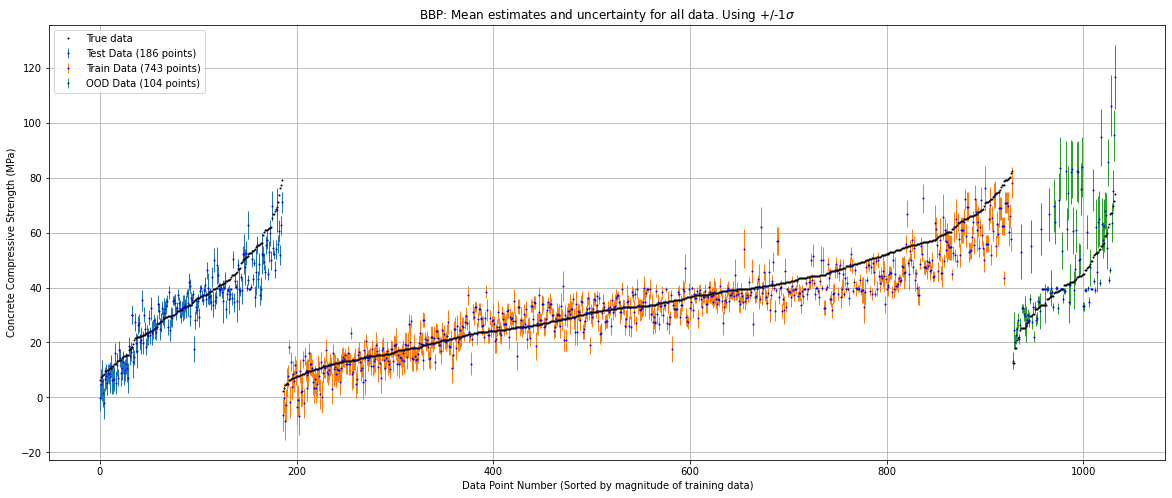

In [34]:
result_plots(samples = [samples_test, samples_train, samples_val],
             labels = ["Test", "Train", "OOD"],
             true = [y_test_np, y_train_np, y_val_np],
             #true_inds = [test_indices, train_indices, val_indices],
             N = -1,
             interval = 1,
             method="SD",
             sort=True,
             bar_method="bars")

 C:\Users\aolux\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
 C:\Users\aolux\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
 C:\Users\aolux\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


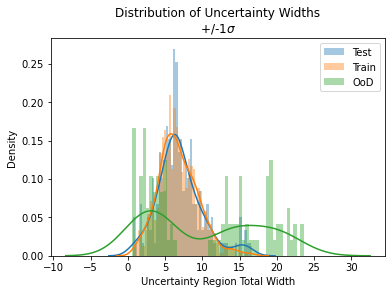

In [30]:
# Plot the distribution of uncertainties
samples = [samples_test, samples_train, samples_val]
labels=["Test", "Train", "OoD"]
for i, s in enumerate(samples):
    upper, lower, means = calculate_credibility(s, 1, "SD")
    upper_uncert = upper-lower 
    sns.distplot(upper_uncert,label=labels[i],bins=50);
    plt.legend()
    plt.title("Distribution of Uncertainty Widths\n+/-1$\sigma$");
    plt.xlabel("Uncertainty Region Total Width");

 C:\Users\aolux\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
 C:\Users\aolux\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
 C:\Users\aolux\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


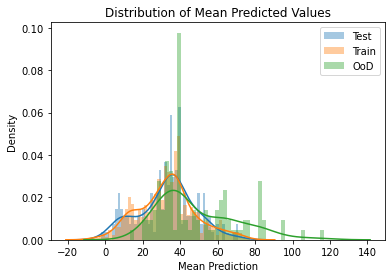

In [31]:
for i, s in enumerate(samples):
    upper, lower, means = calculate_credibility(s, 1, "SD")
    #upper_uncert = upper-lower 
    sns.distplot(means,label=labels[i],bins=50);
    plt.legend()
    plt.title("Distribution of Mean Predicted Values");
    plt.xlabel("Mean Prediction");